# NYC Taxi Trip Duration

In [70]:
from fuzzywuzzy import fuzz

d = DataFrame({'one': ['fuzz', 'wuzz'], 'two': ['fizz', 'woo']})

print(d.apply(lambda s: fuzz.partial_ratio(s['one'], s['two']), axis=1))

d.head()

0    75
1    33
dtype: int64


,one,two
0,fuzz,fizz
1,wuzz,woo


# Loading Training Data

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns #To conduct visual analysis
import statsmodels.api as sm
import time
import xgboost as xgb

from datetime import datetime #This is for object to datetime conversion
from geopy.distance import vincenty, great_circle #for calculating Distance
from ggplot import *
from haversine import haversine
from math import ceil, floor
from numpy import random, float
from pandas import DataFrame
import pickle
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.feature_selection import RFE
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler,LabelEncoder, scale

%matplotlib inline

pd.options.display.float_format = '{:,.15f}'.format

train_file = "E:/GoogleDrive/Interests/Machine_Learning/KAGGLE_COMPETITIONS/train/train.csv"
weather_file = "E:/GoogleDrive/Interests/Machine_Learning/KAGGLE_COMPETITIONS/train/Weather_NYC_Data.csv"
result_file = "E:/GoogleDrive/Interests/Machine_Learning/KAGGLE_COMPETITIONS/test/result.csv"
test_file = "E:/GoogleDrive/Interests/Machine_Learning/KAGGLE_COMPETITIONS/test/test.csv"
afternoon_hours = [12,13,14,15]
earlymorning_hours = [3,4,5]
evening_hours = [16,17,18,19]
latenight_hours = [1,2]
morning_hours = [6,7,8,9,10,11]
night_hours = [0,20,21,22,23]

################################################################################
#NROWS here is only to optimize processing - should be removed while in production ###
################################################################################
df = pd.read_csv(train_file, header = 0,nrows = 15000000)
df_w = pd.read_csv(weather_file, header = 0)
################################################################################
################################################################################
df.head()


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982154846191392,40.767936706542969,-73.964630126953125,40.765602111816406,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415344238267,40.738563537597656,-73.999481201171875,40.731151580810547,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979026794433580,40.763938903808594,-74.005332946777344,40.710086822509773,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040283203125,40.719970703125000,-74.012268066406250,40.706718444824219,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973052978515625,40.793209075927727,-73.972923278808594,40.782520294189453,N,435


Converting Datetime values from Object to Datetime

In [17]:
def get_sec(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

def min_bucket_func(row):
    timestamp = row.strftime("%H:%M:%S")
    row_seconds=get_sec(timestamp)
    if row_seconds <= 300*24*12 :
        return ceil((row_seconds/60)/5)
    else:
        return 400

def hour_quarter_bucket_func(row):
    row_minute = row.minute
    if row_minute != 0:
        return ceil(row_minute /15)
    else:
        return 1

def time_bucket_func(row):
    if row in afternoon_hours :
        return 'Afternoon'
    if row in earlymorning_hours :
        return 'Early Morning'
    if row in evening_hours :
        return 'Evening'
    if row in latenight_hours :
        return 'Late Night'
    if row in morning_hours :
        return 'Morning'
    else:
        return 'Night'

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
df_w['Date'] = pd.to_datetime(df_w['Date'])
df['hour_bucket'] = df['pickup_datetime'].dt.hour
df['weekday'] = df['pickup_datetime'].dt.dayofweek
df['yearweek'] = df['pickup_datetime'].dt.weekofyear
df['yearday'] = df['pickup_datetime'].dt.dayofyear
df['pickup_min_range']=df['pickup_datetime'].apply(lambda x: min_bucket_func(x))
df['timeofday'] = df['pickup_datetime'].dt.hour.apply(lambda x: time_bucket_func(x))
df['hour_quarter_bucket']=df['pickup_datetime'].apply(lambda x: hour_quarter_bucket_func(x))

le=LabelEncoder()
le.fit(df['store_and_fwd_flag'].as_matrix())
df['store_and_fwd_flag']=le.transform(df['store_and_fwd_flag'].fillna('0'))


df['vincenty_distance']=df.apply(lambda x: vincenty((x['pickup_latitude'] ,x['pickup_longitude']),(x['dropoff_latitude'], x['dropoff_longitude'])).miles,axis=1)
df['great_circle_distance']=df.apply(lambda x: great_circle((x['pickup_latitude'] ,x['pickup_longitude']),(x['dropoff_latitude'], x['dropoff_longitude'])).miles,axis=1)
df['haversine_distance']=df.apply(lambda x: haversine((x['pickup_latitude'] ,x['pickup_longitude']),(x['dropoff_latitude'], x['dropoff_longitude']),miles=True),axis=1)

print("The deed is done")


The deed is done


Make a separate column for Month and Date to join Weather Data

In [18]:
df['Date']=df['pickup_datetime'].dt.year.map(str)+'-'+df['pickup_datetime'].dt.month.map(str)+'-'+df['pickup_datetime'].dt.day.map(str)
df['Date']=pd.to_datetime(df['Date'])
df_w['Date']=pd.to_datetime(df_w['Date'])
df_join=df.merge(df_w, on='Date', how='inner')
print("The deed is done")
df_join.head(20)


The deed is done


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,yearweek,yearday,pickup_min_range,timeofday,hour_quarter_bucket,vincenty_distance,great_circle_distance,haversine_distance,Date,tempavg
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982154846191392,40.767936706542969,-73.964630126953125,40.765602111816406,0,...,11,74,209,Evening,2,0.933406298390459,0.931399986841258,0.931137355369325,2016-03-14,46
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090026855469,40.758766174316406,-73.953201293945312,40.765068054199219,0,...,11,74,170,Afternoon,1,1.228002542855021,1.225817030839360,1.225471381133837,2016-03-14,46
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994483947753906,40.745086669921882,-73.998992919921875,40.722709655761719,0,...,11,74,181,Afternoon,1,1.562102869402284,1.564461369515891,1.564020230587083,2016-03-14,46
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944358825683580,40.714488983154297,-73.910530090332031,40.709491729736328,0,...,11,74,53,Early Morning,2,1.809375472885052,1.805538130813023,1.805029014274739,2016-03-14,46
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952880859375000,40.766468048095696,-73.978630065917969,40.761920928955078,0,...,11,74,180,Afternoon,4,1.386891984555231,1.384025815748153,1.383635555127134,2016-03-14,46
5,id3276198,2,2016-03-14 20:31:12,2016-03-14 20:36:18,1,-73.981910705566406,40.766880035400391,-73.982597351074219,40.777179718017578,0,...,11,74,247,Night,3,0.711620842720463,0.712746471943622,0.712545495287444,2016-03-14,46
6,id0871223,1,2016-03-14 07:55:32,2016-03-14 08:08:48,1,-73.953887939453125,40.766952514648438,-73.953849792480483,40.787883758544922,0,...,11,74,96,Morning,4,1.444320580332640,1.446618059082651,1.446210149016431,2016-03-14,46
7,id3860883,1,2016-03-14 20:11:28,2016-03-14 20:24:37,1,-73.954124450683580,40.763881683349609,-73.972961425781250,40.764476776123047,0,...,11,74,243,Night,1,0.989135863866375,0.986902646817818,0.986624364985659,2016-03-14,46
8,id1412157,2,2016-03-14 10:52:01,2016-03-14 11:24:35,1,-73.862754821777344,40.768833160400391,-73.988403320312500,40.734615325927727,0,...,11,74,131,Morning,4,7.003402712040954,6.990626190199548,6.988655008674673,2016-03-14,46
9,id3507184,2,2016-03-14 15:32:44,2016-03-14 15:45:59,2,-73.959411621093750,40.779960632324219,-73.980690002441406,40.782768249511719,0,...,11,74,187,Afternoon,3,1.132773865695496,1.130335663569942,1.130016937218971,2016-03-14,46


# Data Analysis

Check which columns are numeric in data

Data types:

In [7]:
df.dtypes

id                             object
vendor_id                       int64
pickup_datetime        datetime64[ns]
dropoff_datetime       datetime64[ns]
passenger_count                 int64
pickup_longitude              float64
pickup_latitude               float64
dropoff_longitude             float64
dropoff_latitude              float64
store_and_fwd_flag              int64
trip_duration                   int64
pickup_min_range                int64
hour_quarter_bucket             int64
hour_bucket                     int64
timeofday                      object
weekday                         int64
total_distance                  int32
Date                   datetime64[ns]
dtype: object

Finding missing values:

In [8]:
df.count() 

id                     1458644
vendor_id              1458644
pickup_datetime        1458644
dropoff_datetime       1458644
passenger_count        1458644
pickup_longitude       1458644
pickup_latitude        1458644
dropoff_longitude      1458644
dropoff_latitude       1458644
store_and_fwd_flag     1458644
trip_duration          1458644
pickup_min_range       1458644
hour_quarter_bucket    1458644
hour_bucket            1458644
timeofday              1458644
weekday                1458644
total_distance         1458644
Date                   1458644
dtype: int64

So we have do not have any missing data in this data set.

Data range for data is:

In [9]:
print ("pickup_datetime min is",df['pickup_datetime'].min(),"and max is",df['pickup_datetime'].max())
print ("dropoff_datetime min is",df['dropoff_datetime'].min(),"and max is",df['dropoff_datetime'].max())
print ("trip_duration min is",str(df['trip_duration'].min()),"and max is",str(df['trip_duration'].max()))
#print df.loc[[978383]]


pickup_datetime min is 2016-01-01 00:00:17 and max is 2016-06-30 23:59:39
dropoff_datetime min is 2016-01-01 00:03:31 and max is 2016-07-01 23:02:03
trip_duration min is 1 and max is 3526282


Let's see if we the uniqueness in data

In [10]:
df_join.apply(pd.Series.nunique)

id                     1458644
vendor_id                    2
pickup_datetime        1380222
dropoff_datetime       1380377
passenger_count             10
pickup_longitude         23047
pickup_latitude          45245
dropoff_longitude        33821
dropoff_latitude         62519
store_and_fwd_flag           2
trip_duration             7417
pickup_min_range           289
hour_quarter_bucket          4
hour_bucket                 25
timeofday                    6
weekday                      7
total_distance           72615
Date                       182
tempavg                     51
dewavg                      55
humavg                      57
seaavg                      78
visavg                       6
windavg                     17
dtype: int64

# Strip Off Non Numeric Columns

In [139]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
nonnumeric_cols=df_join.select_dtypes(exclude=numerics).columns.values
print ("Non numeric columns to look out for: " + str(nonnumeric_cols))

Non numeric columns to look out for: ['id' 'pickup_datetime' 'dropoff_datetime' 'Date' 'Events']


Do we need these? Let's say no for now

In [140]:
df_join = df_join.drop(['pickup_datetime','dropoff_datetime','Events'],axis=1)
print("Non-numeric columns dropped")

Non-numeric columns dropped


# Fixing missing values..

Let's see if we have any missing values anywhere

In [65]:
df_join.isnull().values.any()

False

# Free up Memory

In [551]:
#Release memory
del df
#del df_join

# Visualization:

Let us see now if there is any relationship between average monthly temperature versus trip duration and total_distance

Correlation between average daily temperature and total trip duration covered is: 0.00355000773389
Correlation between average daily temperature and total distance covered is: 0.488327482984
Correlation between average daily temperature and total rides is: 0.0702823791562


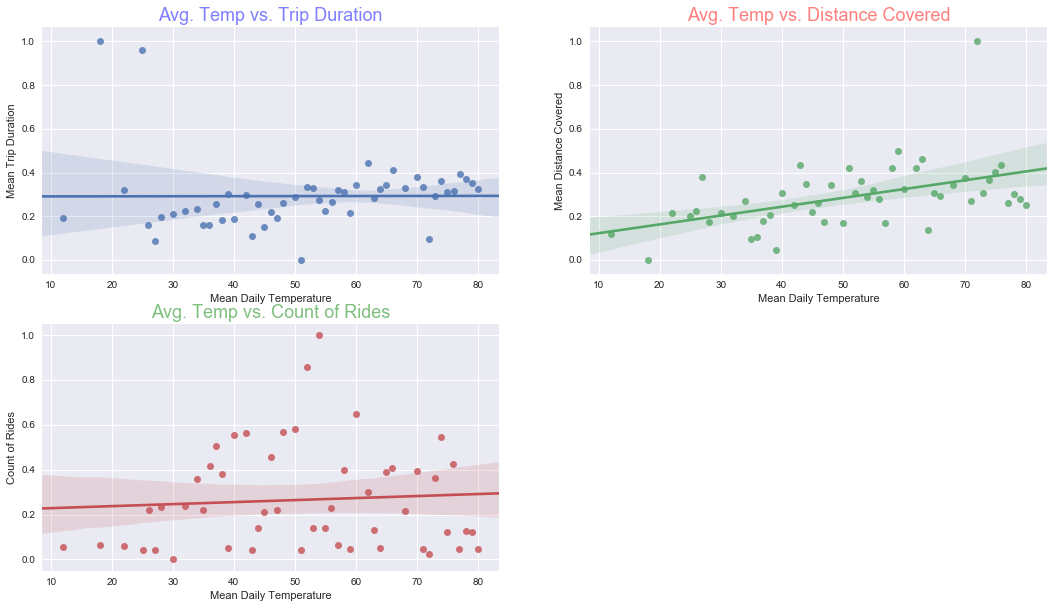

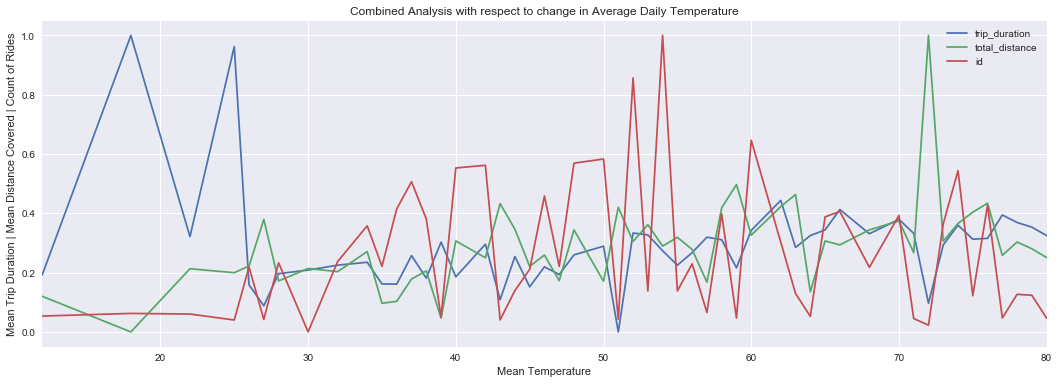

In [11]:
#Aggregation and Joins:
df_bar = df_join.groupby('tempavg', as_index=False)['trip_duration','total_distance'].mean()
df_bar_count21 = df_join.groupby(['tempavg','Date'], as_index=False)['id'].count()
df_bar_count = df_bar_count21.groupby(['tempavg'], as_index=False)['id'].sum()
df_bar_join=df_bar.merge(df_bar_count, on='tempavg', how='inner')

#Scaling:
features_to_scale = ['trip_duration','total_distance','id']
df_bar_join[features_to_scale] -= df_bar_join[features_to_scale].min()  # equivalent to df = df - df.min()
df_bar_join[features_to_scale] /= df_bar_join[features_to_scale].max() 

#Plotting:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

sns.regplot(x='tempavg',y='trip_duration',data=df_bar_join,fit_reg=True, ax=ax1)
sns.regplot(x='tempavg',y='total_distance',data=df_bar_join,fit_reg=True, ax=ax2)
sns.regplot(x='tempavg',y='id',data=df_bar_join,fit_reg=True, ax=ax3)

ax1.set(xlabel='Mean Daily Temperature', ylabel='Mean Trip Duration')
ax2.set(xlabel='Mean Daily Temperature', ylabel='Mean Distance Covered')
ax3.set(xlabel='Mean Daily Temperature', ylabel='Count of Rides')
ax1.set_title('Avg. Temp vs. Trip Duration', fontsize=18,color="b",alpha=0.5)
ax2.set_title('Avg. Temp vs. Distance Covered', fontsize=18,color="r",alpha=0.5)
ax3.set_title('Avg. Temp vs. Count of Rides', fontsize=18,color="g",alpha=0.5)

#Combined Graph:
ax = df_bar_join.plot(x='tempavg',figsize=(18, 6),title = 'Combined Analysis with respect to change in Average Daily Temperature')
ax.set_ylabel('Mean Trip Duration | Mean Distance Covered | Count of Rides')
ax.set_xlabel('Mean Temperature')

#Coorelation Analysis:
print('Correlation between average daily temperature and total trip duration covered is:',str(pd.to_numeric(df_bar_join['tempavg']).corr(df_bar_join['trip_duration'])))
print('Correlation between average daily temperature and total distance covered is:',str(pd.to_numeric(df_bar_join['tempavg']).corr(df_bar_join['total_distance'])))
print('Correlation between average daily temperature and total rides is:',str(pd.to_numeric(df_bar_join['tempavg']).corr(df_bar_join['id'])))


We can make three assumptions here:

When the average daily goes up, there is gradual increase in :

1- Total distance covered is slightly correlated to increase in temperature
2- Total trip Duration is relatively more correlated to increase in temperature
3- Temperature increase does not have any significant impact on total number of rides

Keeping in view point number 3, we can attribute total increase in duration and distance to increase in traffic. Causes for this increase are ambiguous at this point. Something to work on for future

Now, lets do some **Vendor Analysis**

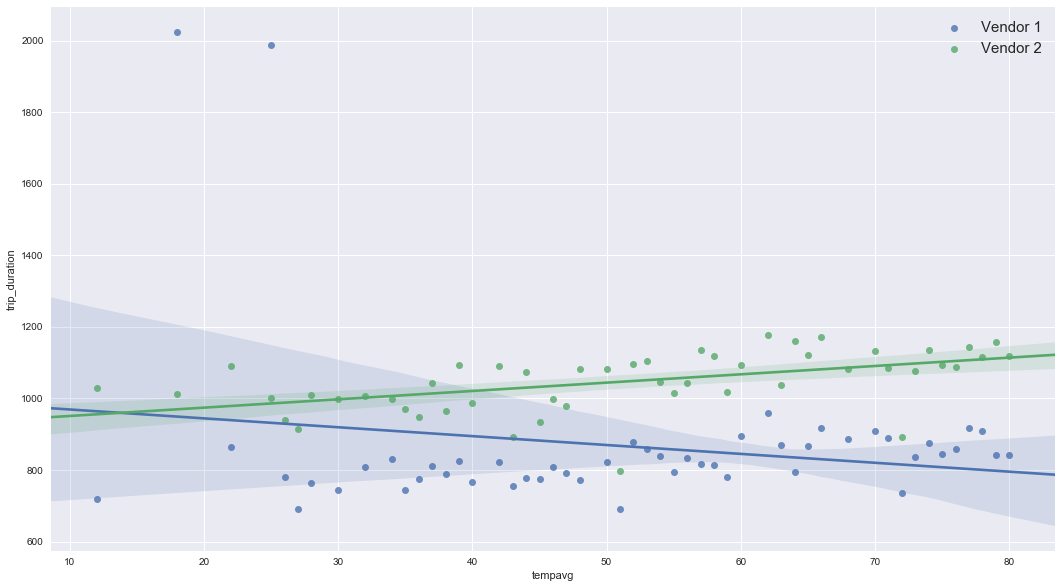

In [12]:
df_bar = df_join.groupby(['tempavg','vendor_id'], as_index=False)['trip_duration'].mean()

fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(111)

sns.regplot(x='tempavg',y='trip_duration',data=df_bar[df_bar['vendor_id']==1],fit_reg=True, ax=ax1, label = 'Vendor 1')
sns.regplot(x='tempavg',y='trip_duration',data=df_bar[df_bar['vendor_id']==2],fit_reg=True, ax=ax1, label = 'Vendor 2')
ax1.legend(loc=1, prop={'size': 15})


Vendor 1 is more inclined to change in temperature than Vendor 2.

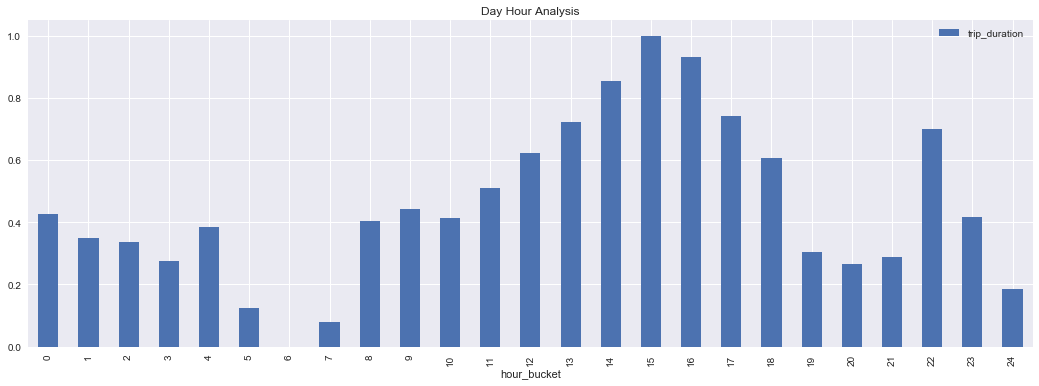

In [13]:
df_bar = df_join.groupby('hour_bucket', as_index=False)['trip_duration'].mean()

features_to_scale = ['trip_duration']
df_bar[features_to_scale] -= df_bar[features_to_scale].min()  # equivalent to df = df - df.min()
df_bar[features_to_scale] /= df_bar[features_to_scale].max() 

ax = df_bar.plot.bar(x='hour_bucket',y='trip_duration',figsize=(18, 6),title = 'Day Hour Analysis')


Overall, there is a spike in travel time at around 3 PM in the afternoon.

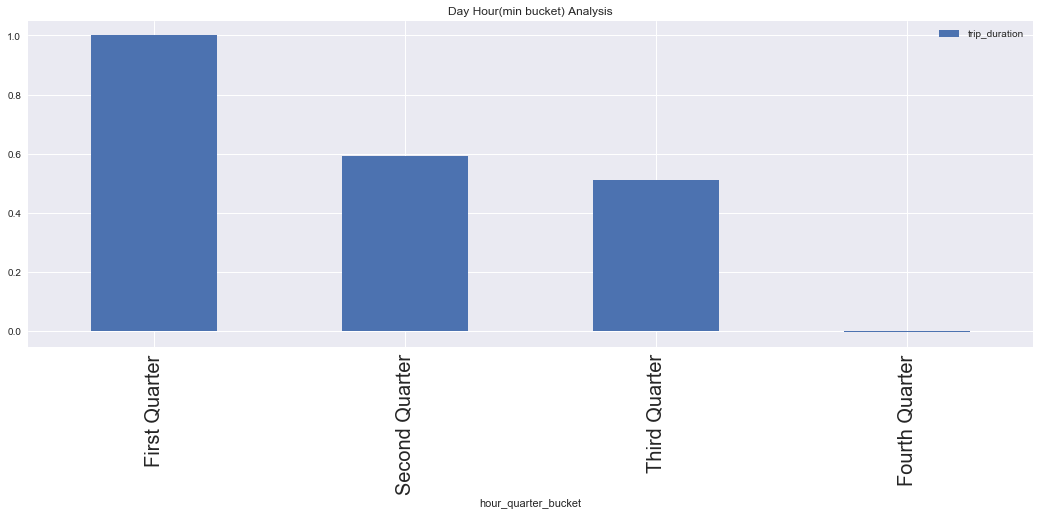

In [24]:
df_bar = df_join.groupby('hour_quarter_bucket', as_index=False)['trip_duration'].mean()
df_bar['trip_duration'] -= df_bar['trip_duration'].min()+0.1  # equivalent to df = df - df.min()
df_bar['trip_duration'] /= df_bar['trip_duration'].max() 
#df_bar['trip_duration'] = scale(df_bar['trip_duration'])
x_ticks = ['First Quarter','Second Quarter','Third Quarter','Fourth Quarter']
ax=df_bar.plot.bar(x='hour_quarter_bucket',figsize=(18, 6),title = 'Day Hour(min bucket) Analysis')
plt.xticks(size = 20)
ax.set_xticklabels(x_ticks)

Interestingly, average travel during first quarters of hours of the day are longest. 

[[<matplotlib.text.Text at 0x310b26d8>,

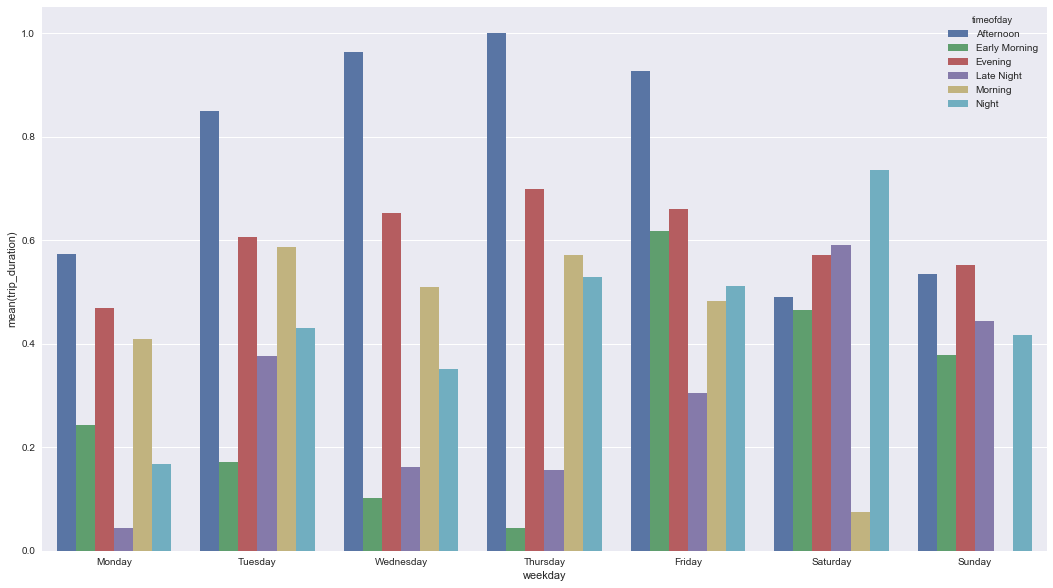

In [25]:
df_bar = df_join.groupby(['timeofday','weekday'], as_index=False)['trip_duration'].mean()

features_to_scale = ['trip_duration']
df_bar[features_to_scale] -= df_bar[features_to_scale].min()  # equivalent to df = df - df.min()
df_bar[features_to_scale] /= df_bar[features_to_scale].max() 

fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(111)
ax = sns.barplot(x="weekday"
                 , y="trip_duration"
                 , data=df_bar,hue='timeofday'
                 , ax=ax1
                 #, label = 'Week day Analysis with respect to time of day'
                )
ax.set(xticklabels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

We see following patterns here: <br>
1- <b>Afternoons</b> of Wednesday,Thursday and Friday have highest trip duraions <br>
2- <b>Early Morning</b> rides of Saturday and Friday are relatively higher than other weekdays <br>
3- <b>Evening</b> of Monday has relatively lower trip duration <br>
4- <b>Late Night</b> trip duration is the most on Saturdays (explaining the saturday night effect) <br>
5- <b>Morning</b> trip duration see significant drop over weekend <br>
6- <b>Night</b> rides on Monday are significantly shorter and that of Saturday are relatively higher than other weekdays

Converting <b>timeofday</b> columns to numeric:

In [19]:
features_to_encode = ['timeofday']
le.fit(df_join[features_to_encode].as_matrix())
df_join[features_to_encode]=le.transform(df_join[features_to_encode])
print ("The deed is done.")

C:\Users\MK255019\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MK255019\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The deed is done.


# Outlier Exclusion

In [20]:
#for Train
df_join=df_join[((df_join.trip_duration - df_join.trip_duration.mean()) / df_join.trip_duration.std()).abs() < 2]

#for Test
#df_join=df_join[((df_join.total_distance - df_join.total_distance.mean()) / df_join.total_distance.std()).abs() < 3]


# Algorithm Application Phase

Prepare for clustering the pickup coordinates:

(-74.277005, -73.609906)

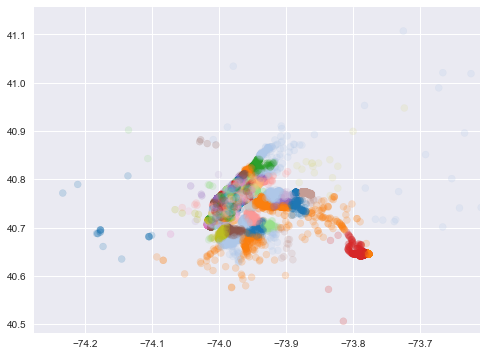

In [23]:
city_long_border = (-74.277005, -73.609906)
city_lat_border = (40.482320, 41.157583)
from sklearn.cluster import MiniBatchKMeans
coords = np.vstack((df_join[['pickup_latitude', 'pickup_longitude']].values,
                    df_join[['dropoff_latitude', 'dropoff_longitude']].values))
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=250
                        ).fit(coords[sample_ind])
df_join['pickup_cluster']=kmeans.predict(df_join[['pickup_latitude', 'pickup_longitude']])
df_join['dropoff_cluster']=kmeans.predict(df_join[['dropoff_latitude', 'dropoff_longitude']])


plt.figure(figsize=(8, 6))
np.random.seed(1987)
N = 100000 
plt.scatter(df_join['pickup_longitude'].values[:N], df_join['pickup_latitude'].values[:N], 
            c=df_join.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)

df_join[['dropoff_cluster','pickup_cluster']]=df_join[['dropoff_cluster','pickup_cluster']].replace(np.nan, '', regex=True)
df_join['dropoff_cluster']=pd.factorize(df_join['dropoff_cluster'])[0]
df_join['pickup_cluster']=pd.factorize(df_join['pickup_cluster'])[0]

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

Let's align our features and confirm if we have anything non numeric in data

In [24]:
features = list(df_join.columns[1:])
list_to_remove=['Date','pickup_datetime','trip_duration','dropoff_datetime']

for row in list_to_remove:
    global feaures
    features.remove(row)

features_extended = features.copy()
features_extended.extend(['prediction_1'
                          ,'prediction_2'
                          ,'prediction_3'
                          
                         ])
print(features)
print(features_extended)

['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'hour_bucket', 'weekday', 'yearweek', 'yearday', 'pickup_min_range', 'timeofday', 'hour_quarter_bucket', 'vincenty_distance', 'great_circle_distance', 'haversine_distance', 'tempavg', 'pickup_cluster', 'dropoff_cluster']
['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'hour_bucket', 'weekday', 'yearweek', 'yearday', 'pickup_min_range', 'timeofday', 'hour_quarter_bucket', 'vincenty_distance', 'great_circle_distance', 'haversine_distance', 'tempavg', 'pickup_cluster', 'dropoff_cluster', 'prediction_1', 'prediction_2', 'prediction_3']


<h2>Train/Test Split</h2>

In [60]:
X_train, X_test, y_train, y_test = train_test_split(df_join[features], df_join.trip_duration, test_size=0.2, random_state=42)

<H2> Stacking Features </H2>

In [61]:
X = scale(X_train[features])
y = y_train

clf_1 = ExtraTreesRegressor()
clf_2 = BaggingRegressor()
clf_3 = RandomForestRegressor()

est_1 = clf_1.fit(X,y)
est_2 = clf_2.fit(X,y)
est_3 = clf_3.fit(X,y)

X_train['prediction_1'] = clf_1.predict(X)
X_train['prediction_2'] = clf_2.predict(X)
X_train['prediction_3'] = clf_3.predict(X)

print ("The deed is done.")

The deed is done.


Saving generated Models:

In [72]:
model_rf = "E:/GoogleDrive/Interests/Machine_Learning/KAGGLE_COMPETITIONS/Models/RandomForest.sav"
model_bag = "E:/GoogleDrive/Interests/Machine_Learning/KAGGLE_COMPETITIONS/Models/Bagging.sav"
model_et = "E:/GoogleDrive/Interests/Machine_Learning/KAGGLE_COMPETITIONS/Models/ExtraTrees.sav"


pickle.dump(clf_1, open(model_1, 'wb'))
pickle.dump(clf_2, open(model_2, 'wb'))
pickle.dump(clf_3, open(model_3, 'wb'))

<h2>Final Prediction on Train/Test</h2>

In [62]:
X_tst = scale(X_test[features])

X_test['prediction_1'] = clf_1.predict(X_tst)
X_test['prediction_2'] = clf_2.predict(X_tst)
X_test['prediction_3'] = clf_3.predict(X_tst)

print ("The deed is done.")

The deed is done.


# Test- Mania

In [42]:
dfTest = pd.read_csv(test_file, header = 0,nrows = 15000000)

print("File Reading deed is done")

dfTest['pickup_datetime'] = pd.to_datetime(dfTest['pickup_datetime'])
df_w['Date'] = pd.to_datetime(df_w['Date'])
dfTest['hour_bucket'] = dfTest['pickup_datetime'].dt.hour
dfTest['weekday'] = dfTest['pickup_datetime'].dt.dayofweek
dfTest['yearweek'] = dfTest['pickup_datetime'].dt.weekofyear
dfTest['yearday'] = dfTest['pickup_datetime'].dt.dayofyear
dfTest['pickup_min_range']=dfTest['pickup_datetime'].apply(lambda x: min_bucket_func(x))
dfTest['timeofday'] = dfTest['pickup_datetime'].dt.hour.apply(lambda x: time_bucket_func(x))
dfTest['hour_quarter_bucket']=dfTest['pickup_datetime'].apply(lambda x: hour_quarter_bucket_func(x))

#le=LabelEncoder()
#le.fit(dfTest['store_and_fwd_flag'].as_matrix())
#dfTest['store_and_fwd_flag']=le.transform(dfTest['store_and_fwd_flag'].fillna('0'))
features_to_encode = ['timeofday','store_and_fwd_flag']
for feats in features_to_encode:
    le.fit(dfTest[feats].as_matrix())
    dfTest[feats]=le.transform(dfTest[feats])


dfTest['vincenty_distance']=dfTest.apply(lambda x: vincenty((x['pickup_latitude'] ,x['pickup_longitude']),(x['dropoff_latitude'], x['dropoff_longitude'])).miles,axis=1)
dfTest['great_circle_distance']=dfTest.apply(lambda x: great_circle((x['pickup_latitude'] ,x['pickup_longitude']),(x['dropoff_latitude'], x['dropoff_longitude'])).miles,axis=1)
dfTest['haversine_distance']=dfTest.apply(lambda x: haversine((x['pickup_latitude'] ,x['pickup_longitude']),(x['dropoff_latitude'], x['dropoff_longitude']),miles=True),axis=1)

print("Features deed is done")


dfTest['Date']=dfTest['pickup_datetime'].dt.year.map(str)+'-'+dfTest['pickup_datetime'].dt.month.map(str)+'-'+dfTest['pickup_datetime'].dt.day.map(str)
dfTest['Date']=pd.to_datetime(dfTest['Date'])
df_w['Date']=pd.to_datetime(df_w['Date'])
dfJoinTest=dfTest.merge(df_w, on='Date', how='inner')

print("Weather deed is done")

"""model1 = model.fit(scale(dfJoinTest[['pickup_longitude', 'pickup_latitude']]))
dfJoinTest['pickup_cluster'] = pd.DataFrame(model1.labels_.astype(int))
model2 = model.fit(scale(dfJoinTest[['dropoff_longitude', 'dropoff_latitude']]))
dfJoinTest['dropoff_cluster'] = pd.DataFrame(model2.labels_.astype(int))
"""
dfJoinTest['pickup_cluster']=kmeans.predict(dfJoinTest[['pickup_latitude', 'pickup_longitude']])
dfJoinTest['dropoff_cluster']=kmeans.predict(dfJoinTest[['dropoff_latitude', 'dropoff_longitude']])


#dfJoinTest[['dropoff_cluster','pickup_cluster']]=dfJoinTest[['dropoff_cluster','pickup_cluster']].replace(np.nan, '', regex=True)
#dfJoinTest['dropoff_cluster']=pd.factorize(dfJoinTest['dropoff_cluster'])[0]
#dfJoinTest['pickup_cluster']=pd.factorize(dfJoinTest['pickup_cluster'])[0]

print("Clustering deed is done")

File Reading deed is done
Features deed is done
Weather deed is done
Clustering deed is done


In [53]:
#dfJoinTest = dfJoinTest.drop(['prediction_1','prediction_2','prediction_3'],axis=1)

features_test = list(dfJoinTest.columns[1:])
list_to_remove=['Date','pickup_datetime'
                #,'results','prediction_1','prediction_2'
               ]

for row in list_to_remove:
    global features_test
    features_test.remove(row)


features_test_extended = features_test.copy()
features_test_extended.extend(['prediction_1'
                               ,'prediction_2'
                               ,'prediction_3'
                              ])

print("Following basic features will be used: ",features_test)
print("Following COMPLEX features will be used: ",features_test_extended)


Following basic features will be used:  ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'hour_bucket', 'weekday', 'yearweek', 'yearday', 'pickup_min_range', 'timeofday', 'hour_quarter_bucket', 'vincenty_distance', 'great_circle_distance', 'haversine_distance', 'tempavg', 'pickup_cluster', 'dropoff_cluster']
Following COMPLEX features will be used:  ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'hour_bucket', 'weekday', 'yearweek', 'yearday', 'pickup_min_range', 'timeofday', 'hour_quarter_bucket', 'vincenty_distance', 'great_circle_distance', 'haversine_distance', 'tempavg', 'pickup_cluster', 'dropoff_cluster', 'prediction_1', 'prediction_2', 'prediction_3']


In [63]:
XTestMain = scale(dfJoinTest[features_test])
dfJoinTest['prediction_1'] = clf_1.predict(XTestMain)
dfJoinTest['prediction_2'] = clf_2.predict(XTestMain)
dfJoinTest['prediction_3'] = clf_3.predict(XTestMain)

print ("The deed is done.")

The deed is done.


# Final Model of XGBoost

In [65]:
dtrain = xgb.DMatrix(X_train[features_extended].values, label=y_train)
dtest  = xgb.DMatrix(X_test[features_extended].values, label=y_test)
dtestMain = xgb.DMatrix(dfJoinTest[features_extended].values)


watchlist = [(dtrain, 'train'), (dtest, 'valid')]

xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

model = xgb.train(xgb_pars, dtrain, 60, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

print ("The FINAL deed is done. Exporting result set...")
np.savetxt(result_file,model.predict(dtestMain) ,delimiter=',')

[0]	train-rmse:750.819	valid-rmse:758.088
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:97.212	valid-rmse:322.267
[20]	train-rmse:51.4296	valid-rmse:328.209
[30]	train-rmse:38.3632	valid-rmse:329.852
[40]	train-rmse:32.7254	valid-rmse:330.902
[50]	train-rmse:30.0211	valid-rmse:330.606
The FINAL deed is done. Exporting result set...


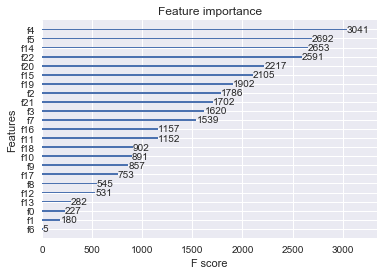

In [66]:
xgb.plot_importance(model)